In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import (
    ResNet50, VGG16, VGG19, MobileNetV2, DenseNet121, EfficientNetB0,
    InceptionV3, Xception, ResNet101, ResNet152
)
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy
import numpy as np
import matplotlib.pyplot as plt
import time

tf.random.set_seed(42)
np.random.seed(42)
set_global_policy('mixed_float16')

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

num_classes = 20
selected_classes = np.random.choice(100, num_classes, replace=False)
train_mask = np.isin(y_train, selected_classes).flatten()
test_mask = np.isin(y_test, selected_classes).flatten()

x_train = x_train[train_mask]
y_train = y_train[train_mask]
x_test = x_test[test_mask]
y_test = y_test[test_mask]

label_map = {old: new for new, old in enumerate(selected_classes)}
y_train = np.array([label_map[old] for old in y_train.flatten()])
y_test = np.array([label_map[old] for old in y_test.flatten()])

train_samples_per_class = 200
test_samples_per_class = 50

train_indices = []
test_indices = []
for cls in range(num_classes):
    train_cls_indices = np.where(y_train == cls)[0][:train_samples_per_class]
    test_cls_indices = np.where(y_test == cls)[0][:test_samples_per_class]
    train_indices.extend(train_cls_indices)
    test_indices.extend(test_cls_indices)

x_train = x_train[train_indices]
y_train = y_train[train_indices]
x_test = x_test[test_indices]
y_test = y_test[test_indices]

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
def preprocess_image(image, label, model_name):
    if model_name in ['InceptionV3', 'Xception']:
        image = tf.image.resize(image, (299, 299))
    else:
        image = tf.image.resize(image, (224, 224))

    if model_name in ['InceptionV3', 'Xception']:
        image = tf.keras.applications.inception_v3.preprocess_input(image)
    elif model_name == 'EfficientNetB0':
        image = tf.keras.applications.efficientnet.preprocess_input(image)
    elif model_name == 'MobileNetV2':
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    elif model_name == 'DenseNet121':
        image = tf.keras.applications.densenet.preprocess_input(image)
    else:
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

In [ ]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))

In [ ]:
models = [
    ('ResNet50', ResNet50), ('VGG16', VGG16), ('VGG19', VGG19),
    ('MobileNetV2', MobileNetV2), ('DenseNet121', DenseNet121),
    ('EfficientNetB0', EfficientNetB0), ('InceptionV3', InceptionV3),
    ('Xception', Xception), ('ResNet101', ResNet101), ('ResNet152', ResNet152)
]

In [ ]:
results = []
start_time = time.time()
for model_name, ModelClass in models:
    print(f"\nTraining {model_name}...")

    train_ds = train_dataset.map(lambda x, y: preprocess_image(x, y, model_name),
                                num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    test_ds = test_dataset.map(lambda x, y: preprocess_image(x, y, model_name),
                               num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    input_shape = (299, 299, 3) if model_name in ['InceptionV3', 'Xception'] else (224, 224, 3)
    base_model = ModelClass(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax', dtype='float32')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_ds, epochs=2, validation_data=test_ds, verbose=1)
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
    results.append((model_name, test_accuracy, test_loss))

    del model
    tf.keras.backend.clear_session()

total_time = time.time() - start_time


Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 158ms/step - accuracy: 0.5368 - loss: 2.0167 - val_accuracy: 0.6870 - val_loss: 1.0384
Epoch 2/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.7661 - loss: 0.8001 - val_accuracy: 0.7580 - val_loss: 0.7136

Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 239ms/step - accuracy: 0.4447 - loss: 2.5590 - val_accuracy: 0.5090 - val_loss: 1.6624
Epoch 2/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 246ms/step - accuracy: 0.6741 - loss: 1.0423 - val_accuracy: 0.6320 - val_loss: 1.1901

Training VGG19...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.4504 - loss: 2.4548 - val_accuracy: 0.5710 - val_loss: 1.4634
Epoch 2/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 303ms/step - accuracy: 0.7164 - loss: 0.9501 - val_accuracy: 0.6780 - val_loss: 1.0243

Trainin

In [ ]:
print("\nPerformance Comparison:")
print(f"{'Model':<15} {'Test Accuracy':<15} {'Test Loss':<10}")
print("-" * 40)
for model_name, acc, loss in results:
    print(f"{model_name:<15} {acc:<15.4f} {loss:<10.4f}")
print(f"\nTotal runtime: {total_time:.2f} seconds")


Performance Comparison:
Model           Test Accuracy   Test Loss 
----------------------------------------
ResNet50        0.7580          0.7136    
VGG16           0.6320          1.1901    
VGG19           0.6780          1.0243    
MobileNetV2     0.7110          0.8929    
DenseNet121     0.7160          0.8426    
EfficientNetB0  0.7970          0.6396    
InceptionV3     0.7280          0.9470    
Xception        0.7500          0.7912    
ResNet101       0.8170          0.5560    
ResNet152       0.8230          0.5569    

Total runtime: 1055.92 seconds


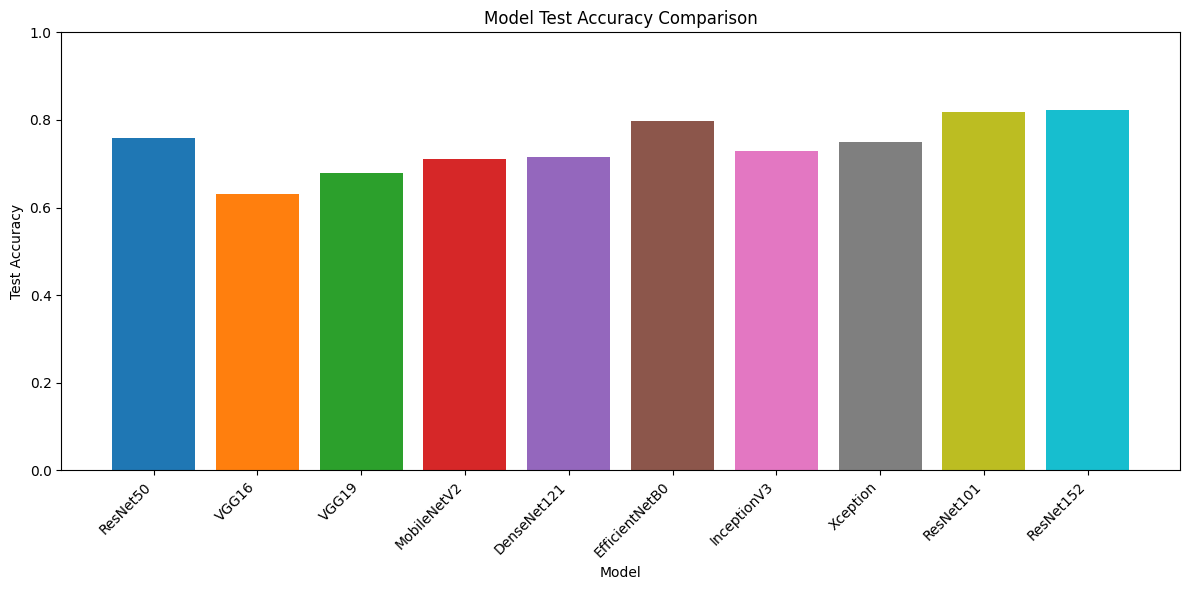

In [ ]:
model_names = [result[0] for result in results]
accuracies = [result[1] for result in results]

plt.figure(figsize=(12, 6))
plt.bar(model_names, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                                       '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Model Test Accuracy Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()